# Tokenize Data
Extract questions directly from mongoDB and dump to CSV file. Perform tokenization and tf-idf analysis.

In [14]:
! mongoexport -h localhost -d cooking -c Posts --type=csv --fields Id,Title,Body,Tags,Score,AcceptedAnswerId,AnswerCount,FavoriteCount -q '{"PostTypeId":"1"}' --out ../data/interim/cooking_questions.csv

2020-04-05T14:33:30.031+0100	connected to: localhost
2020-04-05T14:33:30.697+0100	exported 19308 records


In [15]:
import pandas as pd
import numpy as np
import re
import spacy
from pathlib import Path

In [3]:
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_md')

In [26]:
def split_tags(tags):
    """
    Split tags string into a list
    """
    val = tags.split(' ')
    return val

## Read in the questions Titles and Tags and create strings
Here we want to separate the tags into list and then concatenate them. 

In [16]:
data_path = Path('../data/interim/cooking_questions.csv')
df = pd.read_csv(data_path)

In [17]:
df['Accepted'] = df['AcceptedAnswerId'].copy() > 0
df['FavoriteCount'] = df['FavoriteCount'].copy().fillna(0).astype(int)
df.drop(columns=['Id', 'AcceptedAnswerId'], inplace=True)

In [21]:
df.to_csv(Path('../data/processed/cooking_questions.csv'), index=False)

In [24]:
from ast import literal_eval
df['Tags'] = df['Tags'].apply(literal_eval)
df['Score'] = df['Score'].astype(int)

In [30]:
df['full_text'] = df['Title'] + ' ' + df['Body']

In [31]:
df['full_text']

0        How can I get chewy chocolate chip cookies? My...
1        How should I cook bacon in an oven? I've heard...
2        What is the difference between white and brown...
3        What is the difference between baking soda and...
4        In a tomato sauce recipe, how can I cut the ac...
                               ...                        
19303    What is the temperature of the massive pots of...
19304    Why does rice go bad next day? I'm using a ric...
19305    What is the best way to store potatoes that we...
19306    Preventing that special "cooked-then-refrigera...
19307    Is there an upper limit to the "room temperatu...
Name: full_text, Length: 19308, dtype: object

Concatenate question title and tags together to form strings for parsing

In [28]:
from collections import Counter
flat_list = [item for sublist in df['Tags'].values for item in sublist]
tags_counted = Counter(flat_list)
tags_counted.most_common()

[('baking', 1807),
 ('food-safety', 1568),
 ('substitutions', 1112),
 ('equipment', 957),
 ('bread', 879),
 ('chicken', 585),
 ('eggs', 528),
 ('meat', 527),
 ('storage-method', 510),
 ('sauce', 487),
 ('cake', 487),
 ('flavor', 485),
 ('freezing', 413),
 ('vegetables', 366),
 ('storage-lifetime', 364),
 ('chocolate', 359),
 ('dough', 358),
 ('cheese', 358),
 ('temperature', 358),
 ('oven', 357),
 ('oil', 343),
 ('food-science', 342),
 ('frying', 323),
 ('coffee', 310),
 ('cookies', 309),
 ('sugar', 308),
 ('beef', 305),
 ('fish', 305),
 ('pasta', 296),
 ('fruit', 293),
 ('food-preservation', 284),
 ('cleaning', 282),
 ('rice', 279),
 ('spices', 278),
 ('soup', 276),
 ('salt', 258),
 ('potatoes', 254),
 ('milk', 251),
 ('butter', 244),
 ('flour', 243),
 ('cooking-time', 238),
 ('pizza', 233),
 ('pork', 218),
 ('slow-cooking', 214),
 ('tea', 214),
 ('microwave', 213),
 ('steak', 199),
 ('grilling', 197),
 ('refrigerator', 194),
 ('tomatoes', 190),
 ('boiling', 190),
 ('cookware', 188),


## Use `spacy` to tokenize and lemmatize data
- Remove stop words
- Calculate tf-idf vectors

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop)

find find VERB VB ROOT xxxx True False
array array NOUN NN compound xxxx True False
item item NOUN NN dobj xxxx True False
in in ADP IN prep xx True False
PHP php PROPN NNP compound XXX True False
php php NOUN NN pobj xxx True False


In [35]:
vectorizer = TfidfVectorizer(strip_accents='ascii', lowercase=True, decode_error='ignore',  min_df=5, max_df=0.5, max_features=10000)

In [36]:
vectorizer.fit(df['full_text'].copy())

TfidfVectorizer(analyzer='word', binary=False, decode_error='ignore',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.5, max_features=10000,
                min_df=5, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents='ascii',
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [37]:
vectors = vectorizer.transform(df['full_text'].copy())
vectorized_series = [vectors[i] for i in range(vectors.shape[0])]

In [47]:
import spacy

In [48]:
nlp = spacy.load('en_core_web_md', disable=["parser", "tagger", "ner", "textcat"])
df["vectors"] = df["full_text"].apply(lambda x: nlp(x).vector)
vectorized_features= np.vstack(df["vectors"])

In [43]:
import umap

In [44]:
from sklearn.cluster import KMeans

In [49]:
umap_embedder = umap.UMAP()
umap_features = umap_embedder.fit_transform(vectorized_features)

/home/yl238/projects/stackoverflow/.env/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../.env/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/yl238/projects/stackoverflow/.env/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../.env/lib/python3.7/site-packages/uma

In [54]:
import matplotlib.pyplot as plt

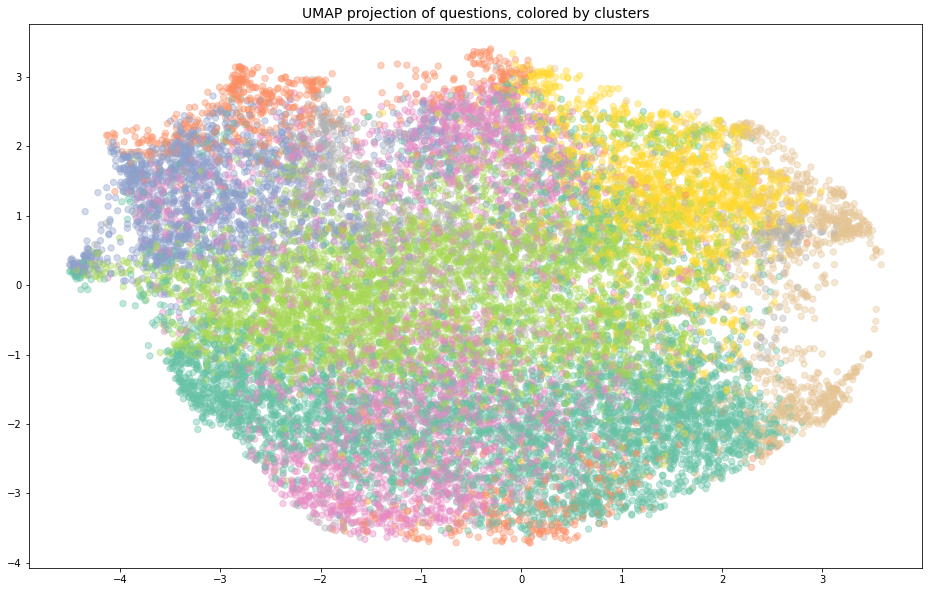

In [56]:
# Choose number of clusters and colormap
n_clusters=10
cmap = plt.get_cmap("Set2")
fig = plt.figure(figsize=(16, 10))


# Fit clustering algorithm to our vectorized features
clus = KMeans(n_clusters=n_clusters, random_state=10)
clusters = clus.fit_predict(vectorized_features)

# Plot the dimentionality reduced features on a 2D plane
plt.scatter(umap_features[:, 0], umap_features[:, 1], 
            c=[cmap(x/n_clusters) for x in clusters], s=40, alpha=.4)
plt.title('UMAP projection of questions, colored by clusters', fontsize=14);

In [60]:
import hdbscan

In [61]:
clusterer = hdbscan.HDBSCAN()

In [62]:
clusterer.fit(vectorized_features)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)